In [53]:
import covid_feature_extraction
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [78]:
def lasso_coefs(X, y, feature_labels, plot=False, save=False, save_county=None, save_title=None):
    kf = KFold(n_splits=5)
    lambdas = np.logspace(-8,-1,100)

    mse_nondecreasing=True
    counter = 0
    scores = []
    min_error = 1e6
    min_index = 0
    coefs = []

    X = np.array(X)
    y = np.array(y)

    for i in range(len(lambdas)):
        score_arr = []
        coef_arr = []
        for train_indices, test_indices in kf.split(X):
            X_train, X_test = X[train_indices], X[test_indices]
            y_train, y_test = y[train_indices], y[test_indices]

            lasso = Lasso(alpha=lambdas[i],max_iter=10000).fit(X_train, y_train)
            coef_arr.append(lasso.coef_)
            y_pred = lasso.predict(X_test)
            score_arr.append(mean_squared_error(y_test, y_pred))
        avg_score = np.array(score_arr).mean()
        if avg_score <= min_error:
            if counter >= 1:
                mse_nondecreasing = False
            counter += 1
            min_error = avg_score
            min_index = i
            best_lambda = lambdas[i]
        scores.append(avg_score)
        coefs.append(np.array(coef_arr).mean(axis=0))
    #print("Best Lasso Coefs: " + str(coefs[min_index]))
    print("Best MSE: " + str(min_error))

    if plot:
        fig, ax1 = plt.subplots(figsize=(15,6))
        coefs = np.array(coefs)
        for i in range(len(coefs.T)):
            ax1.plot(lambdas,coefs[:,i],label=feature_labels[i])
        ax1.set_xscale("log")
        ax1.set_ylabel("Coefficients",fontsize=22,labelpad=8)
        ax1.set_xlabel(r"$\lambda$",fontsize=22,labelpad=8)
        ax1.tick_params(axis='both', which='major', labelsize=16)
        ax1.legend(loc='upper left',fontsize=12)

        ax2 = ax1.twinx()

        ax2.plot(lambdas,scores,color='k',linestyle='--',alpha=0.5,label="Error")
        if not mse_nondecreasing:
            ax2.axvline(best_lambda,color='red',linestyle='--',alpha=0.5)
        ax2.set_ylabel("Mean Squared Error",fontsize=22,labelpad=8)
        ax2.tick_params(axis='both', which='major', labelsize=16)

        if save:
            plt.title(save_title,fontsize=24,weight='bold')
            plt.savefig("{}_lasso_coefs.png".format(save_county))
        plt.show()
    
    return coefs[min_index]

# Population Not Staying Home

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Best MSE: 0.0007793967048470331


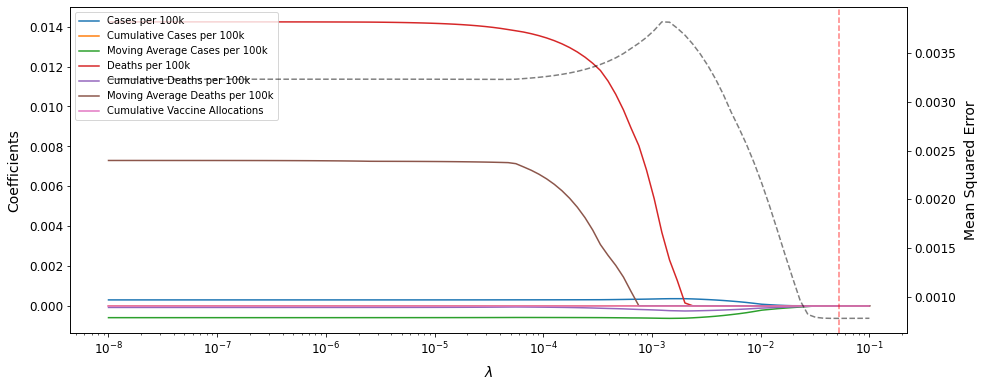

Cases per 100k:		0.0

Cumulative Cases per 100k:		-4.2802207747181275e-06

Moving Average Cases per 100k:		0.0

Deaths per 100k:		0.0

Cumulative Deaths per 100k:		0.0

Moving Average Deaths per 100k:		0.0

Cumulative Vaccine Allocations:		1.9272717332583644e-08



In [55]:
alloc_dates, state_y, cumul_doses = covid_feature_extraction.cumul_doses("Georgia","GA","Population")
state_trip_dates, state_y, state_X, feature_labels = covid_feature_extraction.state_extraction("Population")

padded_cumul_doses = np.pad(cumul_doses,pad_width=(state_X.shape[0]-len(cumul_doses),0))
state_X = np.concatenate([state_X,padded_cumul_doses.reshape(len(padded_cumul_doses),1)],axis=1)

feature_labels += ["Cumulative Vaccine Allocations"]

state_coefs = lasso_coefs(state_X, state_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print("{}:\t\t{}".format(feature_labels[i],state_coefs[i]))
    print()

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Best MSE: 0.0007962976998635537


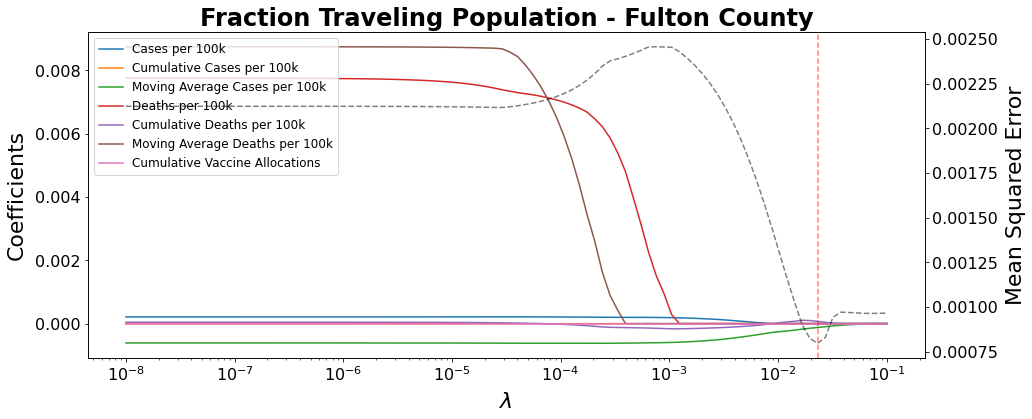

Cases per 100k:		0.0

Cumulative Cases per 100k:		-5.412768438446755e-06

Moving Average Cases per 100k:		-0.00012311282034595128

Deaths per 100k:		0.0

Cumulative Deaths per 100k:		6.952411974110511e-05

Moving Average Deaths per 100k:		0.0

Cumulative Vaccine Allocations:		1.8656077382331257e-08



In [75]:
alloc_dates, state_y, cumul_doses = covid_feature_extraction.cumul_doses("Georgia","GA","Population")
dates, fulton_y, fulton_X, feature_labels = covid_feature_extraction.county_extraction("Fulton","Population")

padded_cumul_doses = np.pad(cumul_doses,pad_width=(fulton_X.shape[0]-len(cumul_doses),0))
fulton_X = np.concatenate([fulton_X,padded_cumul_doses.reshape(len(padded_cumul_doses),1)],axis=1)

feature_labels += ["Cumulative Vaccine Allocations"]

fulton_coefs = lasso_coefs(fulton_X, fulton_y, feature_labels, plot=True, save=True, save_county="fulton", save_title="Fraction Traveling Population - Fulton County")
for i in range(len(feature_labels)):
    print("{}:\t\t{}".format(feature_labels[i],fulton_coefs[i]))
    print()

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Best MSE: 0.0007082302536360549


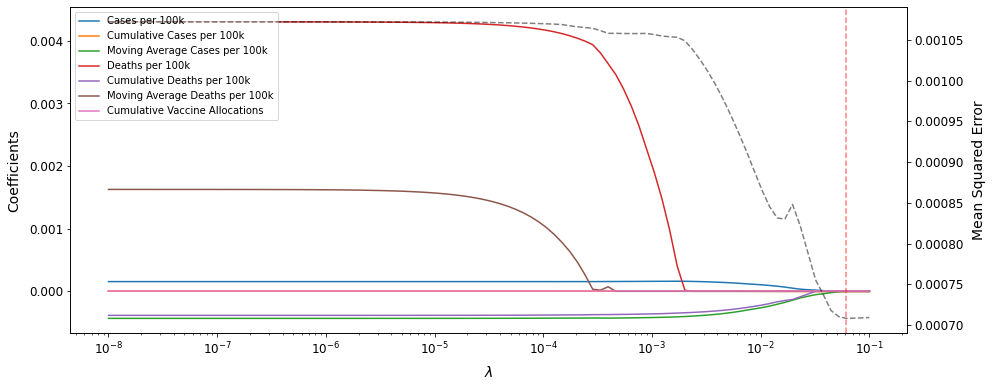

Cases per 100k:		0.0

Cumulative Cases per 100k:		-3.5000702648743916e-06

Moving Average Cases per 100k:		0.0

Deaths per 100k:		0.0

Cumulative Deaths per 100k:		0.0

Moving Average Deaths per 100k:		0.0

Cumulative Vaccine Allocations:		1.7943309328648433e-08



In [57]:
alloc_dates, state_y, cumul_doses = covid_feature_extraction.cumul_doses("Georgia","GA","Population")
dates, lowndes_y, lowndes_X, feature_labels = covid_feature_extraction.county_extraction("Lowndes","Population")

padded_cumul_doses = np.pad(cumul_doses,pad_width=(lowndes_X.shape[0]-len(cumul_doses),0))
lowndes_X = np.concatenate([lowndes_X,padded_cumul_doses.reshape(len(padded_cumul_doses),1)],axis=1)

feature_labels += ["Cumulative Vaccine Allocations"]

lowndes_coefs = lasso_coefs(lowndes_X, lowndes_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print("{}:\t\t{}".format(feature_labels[i],lowndes_coefs[i]))
    print()

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Best MSE: 0.0007849031798958042


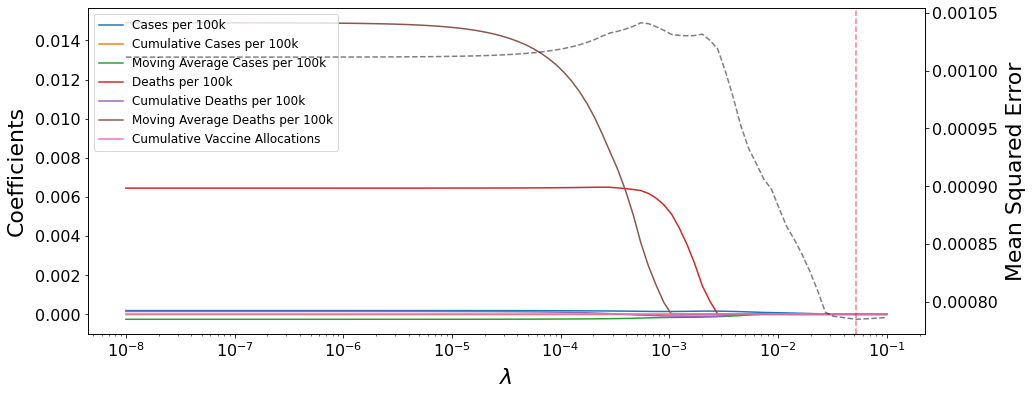

Cases per 100k:		0.0

Cumulative Cases per 100k:		-8.446428083296537e-06

Moving Average Cases per 100k:		0.0

Deaths per 100k:		0.0

Cumulative Deaths per 100k:		0.0

Moving Average Deaths per 100k:		0.0

Cumulative Vaccine Allocations:		1.7793182435217093e-08



In [81]:
alloc_dates, state_y, cumul_doses = covid_feature_extraction.cumul_doses("Georgia","GA","Population")
dates, chatham_y, chatham_X, feature_labels = covid_feature_extraction.county_extraction("Chatham","Population")

padded_cumul_doses = np.pad(cumul_doses,pad_width=(chatham_X.shape[0]-len(cumul_doses),0))
chatham_X = np.concatenate([chatham_X,padded_cumul_doses.reshape(len(padded_cumul_doses),1)],axis=1)

feature_labels += ["Cumulative Vaccine Allocations"]

chatham_coefs = lasso_coefs(chatham_X, chatham_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print("{}:\t\t{}".format(feature_labels[i],chatham_coefs[i]))
    print()

# Long Trips

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Best MSE: 2.816253722748751e-05


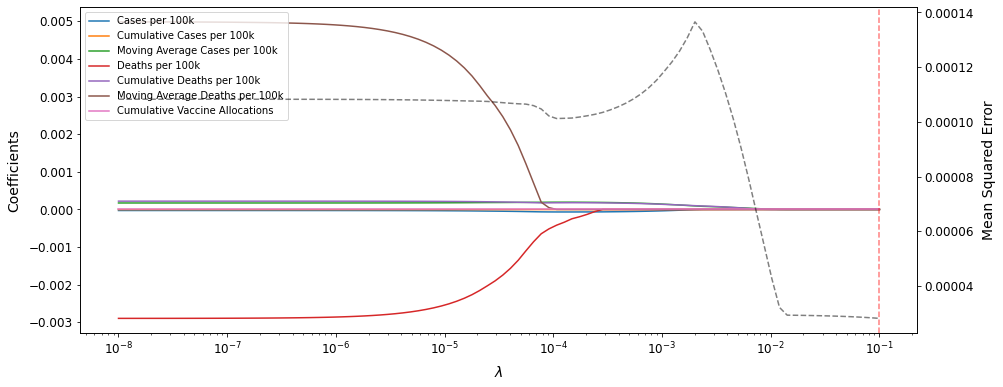

Cases per 100k:		0.0

Cumulative Cases per 100k:		-1.478427600677053e-07

Moving Average Cases per 100k:		0.0

Deaths per 100k:		0.0

Cumulative Deaths per 100k:		0.0

Moving Average Deaths per 100k:		0.0

Cumulative Vaccine Allocations:		-9.608306604724933e-10



In [59]:
alloc_dates, state_y, cumul_doses = covid_feature_extraction.cumul_doses("Georgia","GA","Long")
state_trip_dates, state_y, state_X, feature_labels = covid_feature_extraction.state_extraction("Long")

padded_cumul_doses = np.pad(cumul_doses,pad_width=(state_X.shape[0]-len(cumul_doses),0))
state_X = np.concatenate([state_X,padded_cumul_doses.reshape(len(padded_cumul_doses),1)],axis=1)

feature_labels += ["Cumulative Vaccine Allocations"]

state_coefs = lasso_coefs(state_X, state_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print("{}:\t\t{}".format(feature_labels[i],state_coefs[i]))
    print()

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Best MSE: 8.640721484177771e-05


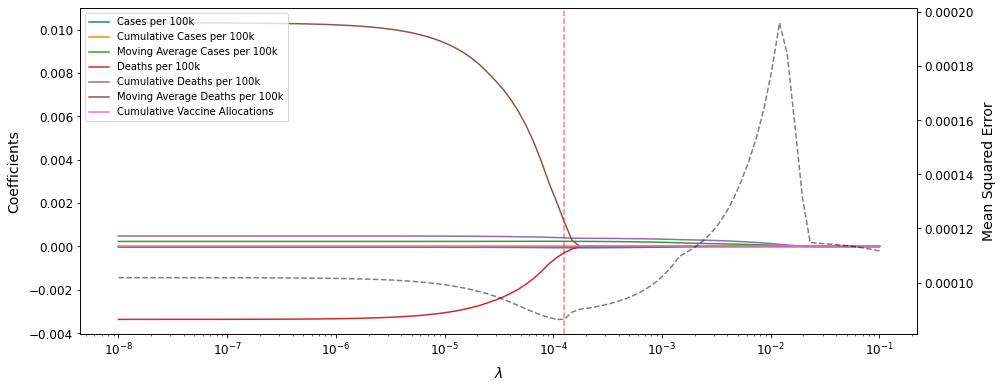

Cases per 100k:		-6.11902608195486e-05

Cumulative Cases per 100k:		-6.631062411125357e-06

Moving Average Cases per 100k:		0.00023600818726392817

Deaths per 100k:		-0.0002855266865734043

Cumulative Deaths per 100k:		0.0003956199506419513

Moving Average Deaths per 100k:		0.0011337830213272917

Cumulative Vaccine Allocations:		1.1595011558104919e-09



In [60]:
alloc_dates, state_y, cumul_doses = covid_feature_extraction.cumul_doses("Georgia","GA","Long")
dates, fulton_y, fulton_X, feature_labels = covid_feature_extraction.county_extraction("Fulton","Long")

padded_cumul_doses = np.pad(cumul_doses,pad_width=(fulton_X.shape[0]-len(cumul_doses),0))
fulton_X = np.concatenate([fulton_X,padded_cumul_doses.reshape(len(padded_cumul_doses),1)],axis=1)

feature_labels += ["Cumulative Vaccine Allocations"]

fulton_coefs = lasso_coefs(fulton_X, fulton_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print("{}:\t\t{}".format(feature_labels[i],fulton_coefs[i]))
    print()

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Best MSE: 8.66123854311877e-05


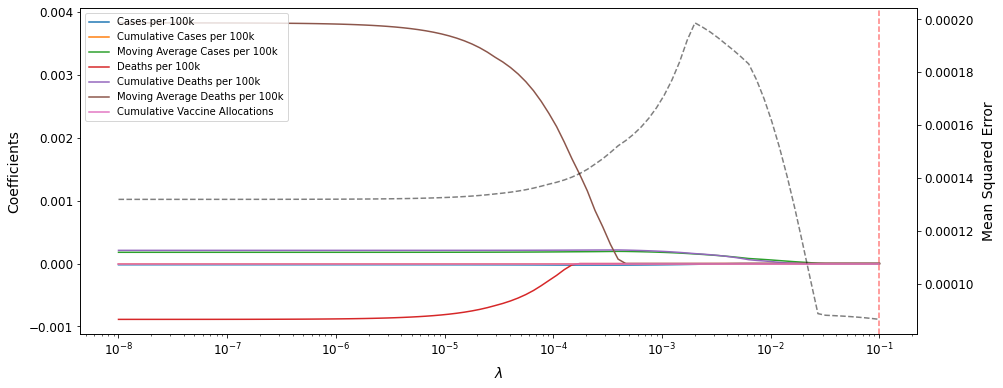

Cases per 100k:		0.0

Cumulative Cases per 100k:		3.6614968004285474e-08

Moving Average Cases per 100k:		0.0

Deaths per 100k:		0.0

Cumulative Deaths per 100k:		0.0

Moving Average Deaths per 100k:		0.0

Cumulative Vaccine Allocations:		-2.7856957274375427e-09



In [61]:
alloc_dates, state_y, cumul_doses = covid_feature_extraction.cumul_doses("Georgia","GA","Long")
dates, lowndes_y, lowndes_X, feature_labels = covid_feature_extraction.county_extraction("Lowndes","Long")

padded_cumul_doses = np.pad(cumul_doses,pad_width=(lowndes_X.shape[0]-len(cumul_doses),0))
lowndes_X = np.concatenate([lowndes_X,padded_cumul_doses.reshape(len(padded_cumul_doses),1)],axis=1)

feature_labels += ["Cumulative Vaccine Allocations"]

lowndes_coefs = lasso_coefs(lowndes_X, lowndes_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print("{}:\t\t{}".format(feature_labels[i],lowndes_coefs[i]))
    print()

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Best MSE: 2.851663188296312e-05


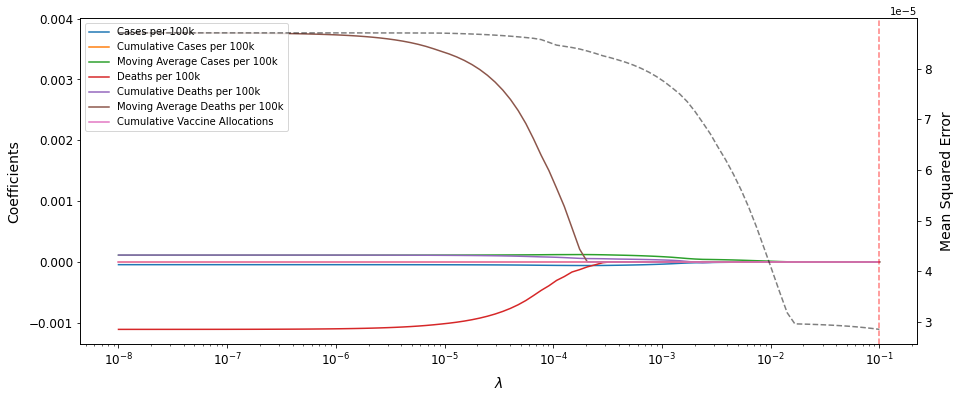

Cases per 100k:		0.0

Cumulative Cases per 100k:		2.350074327159201e-07

Moving Average Cases per 100k:		0.0

Deaths per 100k:		0.0

Cumulative Deaths per 100k:		0.0

Moving Average Deaths per 100k:		0.0

Cumulative Vaccine Allocations:		-1.352079054667852e-09



In [62]:
alloc_dates, state_y, cumul_doses = covid_feature_extraction.cumul_doses("Georgia","GA","Long")
dates, chatham_y, chatham_X, feature_labels = covid_feature_extraction.county_extraction("Chatham","Long")

padded_cumul_doses = np.pad(cumul_doses,pad_width=(chatham_X.shape[0]-len(cumul_doses),0))
chatham_X = np.concatenate([chatham_X,padded_cumul_doses.reshape(len(padded_cumul_doses),1)],axis=1)

feature_labels += ["Cumulative Vaccine Allocations"]

chatham_coefs = lasso_coefs(chatham_X, chatham_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print("{}:\t\t{}".format(feature_labels[i],chatham_coefs[i]))
    print()

# Medium Trips

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Best MSE: 0.0007708179556475808


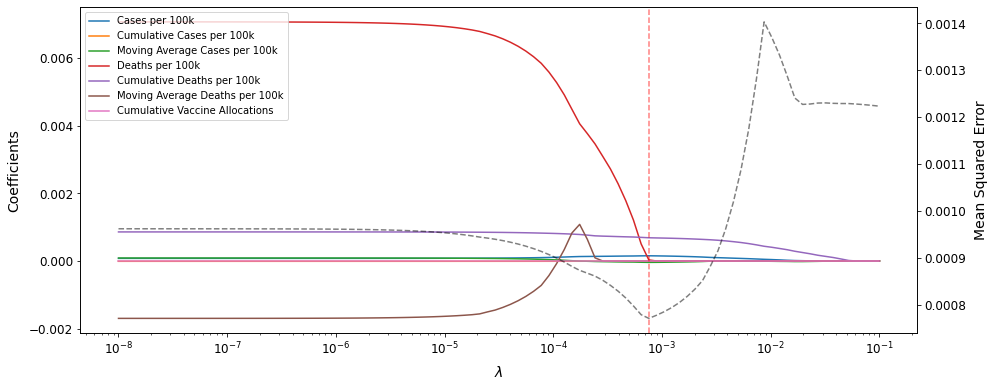

Cases per 100k:		0.00015379628112460316

Cumulative Cases per 100k:		-6.692226689648925e-06

Moving Average Cases per 100k:		-4.140231968275526e-05

Deaths per 100k:		3.114474389185968e-05

Cumulative Deaths per 100k:		0.0006872234937700571

Moving Average Deaths per 100k:		0.0

Cumulative Vaccine Allocations:		-8.46038297710599e-09



In [63]:
alloc_dates, state_y, cumul_doses = covid_feature_extraction.cumul_doses("Georgia","GA","Medium")
state_trip_dates, state_y, state_X, feature_labels = covid_feature_extraction.state_extraction("Medium")

padded_cumul_doses = np.pad(cumul_doses,pad_width=(state_X.shape[0]-len(cumul_doses),0))
state_X = np.concatenate([state_X,padded_cumul_doses.reshape(len(padded_cumul_doses),1)],axis=1)

feature_labels += ["Cumulative Vaccine Allocations"]

state_coefs = lasso_coefs(state_X, state_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print("{}:\t\t{}".format(feature_labels[i],state_coefs[i]))
    print()

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Best MSE: 0.0013179704622938498


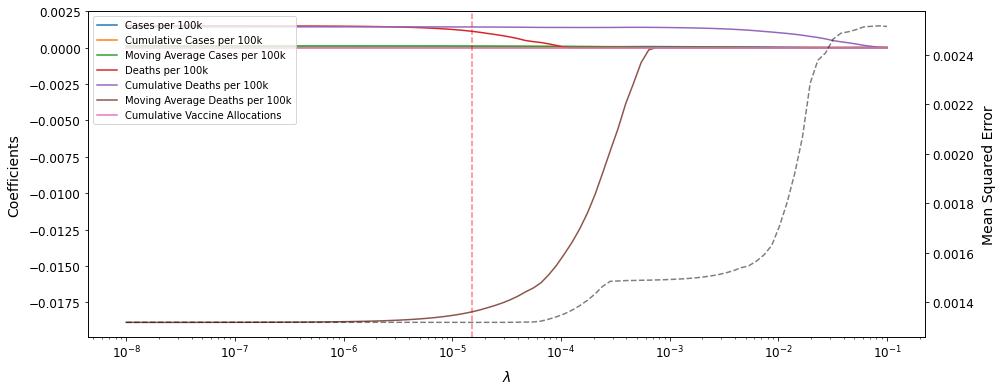

Cases per 100k:		3.4096003627890326e-05

Cumulative Cases per 100k:		-1.3561653996571675e-05

Moving Average Cases per 100k:		0.00011186706754993604

Deaths per 100k:		0.0011187975754848203

Cumulative Deaths per 100k:		0.0014168790355145449

Moving Average Deaths per 100k:		-0.018154973846080384

Cumulative Vaccine Allocations:		-1.13800317036222e-08



In [64]:
alloc_dates, state_y, cumul_doses = covid_feature_extraction.cumul_doses("Georgia","GA","Medium")
dates, fulton_y, fulton_X, feature_labels = covid_feature_extraction.county_extraction("Fulton","Medium")

padded_cumul_doses = np.pad(cumul_doses,pad_width=(fulton_X.shape[0]-len(cumul_doses),0))
fulton_X = np.concatenate([fulton_X,padded_cumul_doses.reshape(len(padded_cumul_doses),1)],axis=1)

feature_labels += ["Cumulative Vaccine Allocations"]

fulton_coefs = lasso_coefs(fulton_X, fulton_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print("{}:\t\t{}".format(feature_labels[i],fulton_coefs[i]))
    print()

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Best MSE: 0.0002469098505812997


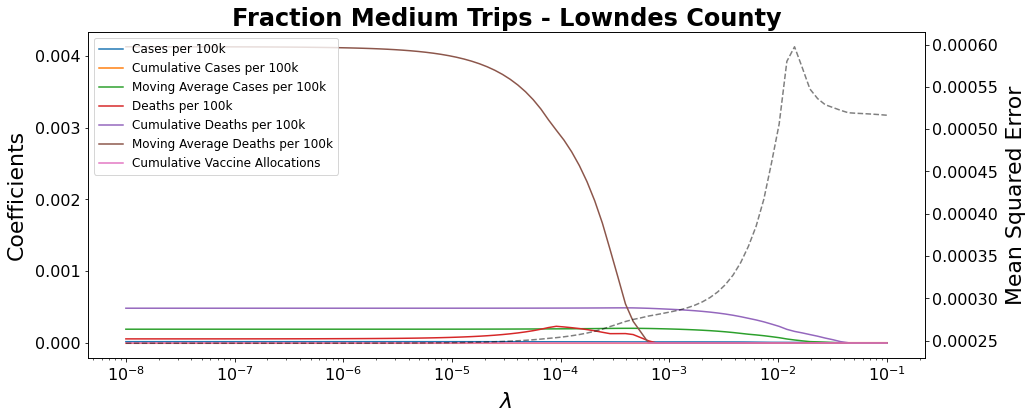

Cases per 100k:		1.6965430860255356e-05

Cumulative Cases per 100k:		-5.448254732939467e-06

Moving Average Cases per 100k:		0.00019053942366709133

Deaths per 100k:		5.5676928335633335e-05

Cumulative Deaths per 100k:		0.0004830065305646042

Moving Average Deaths per 100k:		0.0041250978846527845

Cumulative Vaccine Allocations:		1.8203053547094892e-09



In [80]:
alloc_dates, state_y, cumul_doses = covid_feature_extraction.cumul_doses("Georgia","GA","Medium")
dates, lowndes_y, lowndes_X, feature_labels = covid_feature_extraction.county_extraction("Lowndes","Medium")

padded_cumul_doses = np.pad(cumul_doses,pad_width=(lowndes_X.shape[0]-len(cumul_doses),0))
lowndes_X = np.concatenate([lowndes_X,padded_cumul_doses.reshape(len(padded_cumul_doses),1)],axis=1)

feature_labels += ["Cumulative Vaccine Allocations"]

lowndes_coefs = lasso_coefs(lowndes_X, lowndes_y, feature_labels, plot=True, save=True, save_county="lowndes", save_title="Fraction Medium Trips - Lowndes County")
for i in range(len(feature_labels)):
    print("{}:\t\t{}".format(feature_labels[i],lowndes_coefs[i]))
    print()

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Best MSE: 0.00035394671526651296


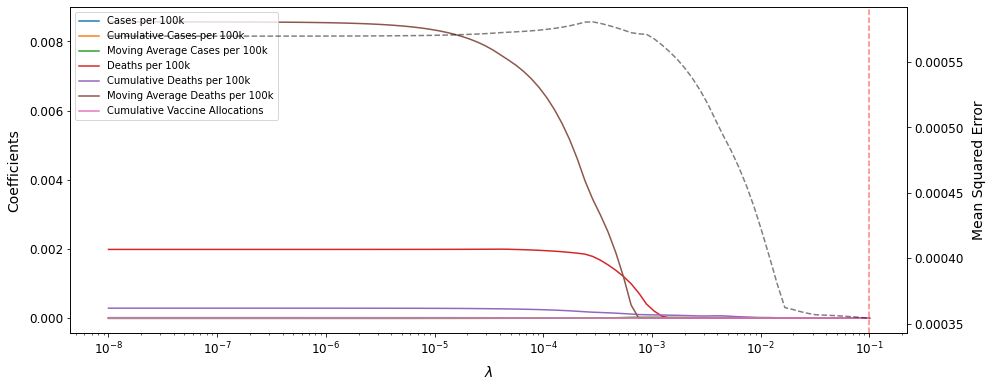

Cases per 100k:		0.0

Cumulative Cases per 100k:		3.9261636379920415e-06

Moving Average Cases per 100k:		0.0

Deaths per 100k:		0.0

Cumulative Deaths per 100k:		0.0

Moving Average Deaths per 100k:		0.0

Cumulative Vaccine Allocations:		-4.389995258226191e-09



In [66]:
alloc_dates, state_y, cumul_doses = covid_feature_extraction.cumul_doses("Georgia","GA","Medium")
dates, chatham_y, chatham_X, feature_labels = covid_feature_extraction.county_extraction("Chatham","Medium")

padded_cumul_doses = np.pad(cumul_doses,pad_width=(chatham_X.shape[0]-len(cumul_doses),0))
chatham_X = np.concatenate([chatham_X,padded_cumul_doses.reshape(len(padded_cumul_doses),1)],axis=1)

feature_labels += ["Cumulative Vaccine Allocations"]

chatham_coefs = lasso_coefs(chatham_X, chatham_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print("{}:\t\t{}".format(feature_labels[i],chatham_coefs[i]))
    print()

# Short Trips

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Best MSE: 0.0013409950715458975


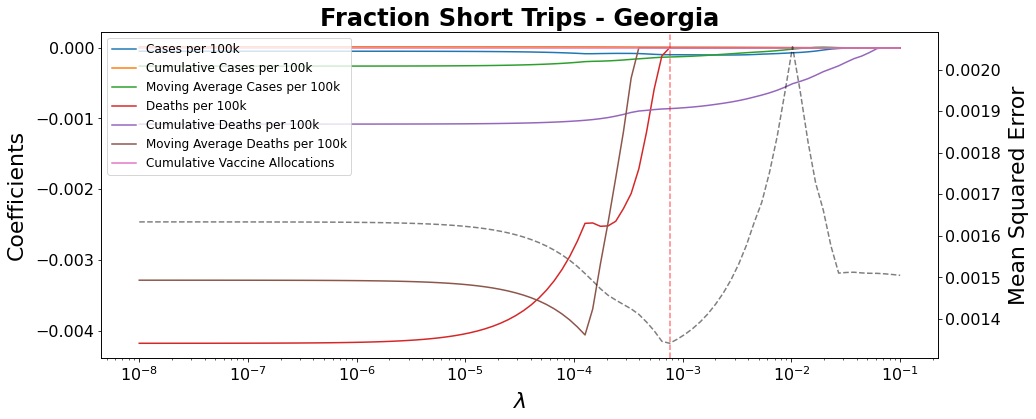

Cases per 100k:		-9.834341823581401e-05

Cumulative Cases per 100k:		1.0364770182957925e-05

Moving Average Cases per 100k:		-0.0001307956719421541

Deaths per 100k:		0.0

Cumulative Deaths per 100k:		-0.0008615043286540177

Moving Average Deaths per 100k:		0.0

Cumulative Vaccine Allocations:		8.371485383391138e-09



In [82]:
alloc_dates, state_y, cumul_doses = covid_feature_extraction.cumul_doses("Georgia","GA","Short")
state_trip_dates, state_y, state_X, feature_labels = covid_feature_extraction.state_extraction("Short")

padded_cumul_doses = np.pad(cumul_doses,pad_width=(state_X.shape[0]-len(cumul_doses),0))
state_X = np.concatenate([state_X,padded_cumul_doses.reshape(len(padded_cumul_doses),1)],axis=1)

feature_labels += ["Cumulative Vaccine Allocations"]

state_coefs = lasso_coefs(state_X, state_y, feature_labels, plot=True, save=True, save_county="georgia", save_title="Fraction Short Trips - Georgia")
for i in range(len(feature_labels)):
    print("{}:\t\t{}".format(feature_labels[i],state_coefs[i]))
    print()

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Best MSE: 0.0019983586729399806


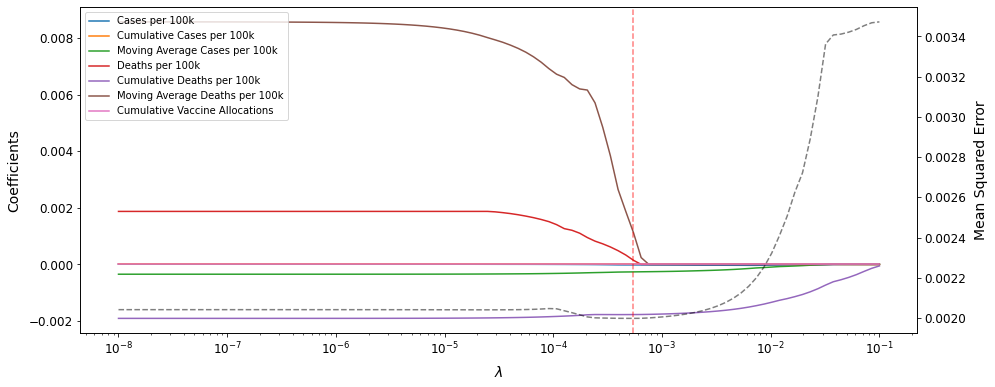

Cases per 100k:		-1.8271237936332416e-05

Cumulative Cases per 100k:		2.0032078186010977e-05

Moving Average Cases per 100k:		-0.0002648732041255639

Deaths per 100k:		0.00014502857208989172

Cumulative Deaths per 100k:		-0.0017722781069127946

Moving Average Deaths per 100k:		0.0011231776603750656

Cumulative Vaccine Allocations:		1.0909521029751352e-08



In [68]:
alloc_dates, state_y, cumul_doses = covid_feature_extraction.cumul_doses("Georgia","GA","Short")
dates, fulton_y, fulton_X, feature_labels = covid_feature_extraction.county_extraction("Fulton","Short")

padded_cumul_doses = np.pad(cumul_doses,pad_width=(fulton_X.shape[0]-len(cumul_doses),0))
fulton_X = np.concatenate([fulton_X,padded_cumul_doses.reshape(len(padded_cumul_doses),1)],axis=1)

feature_labels += ["Cumulative Vaccine Allocations"]

fulton_coefs = lasso_coefs(fulton_X, fulton_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print("{}:\t\t{}".format(feature_labels[i],fulton_coefs[i]))
    print()

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Best MSE: 0.000499301854504458


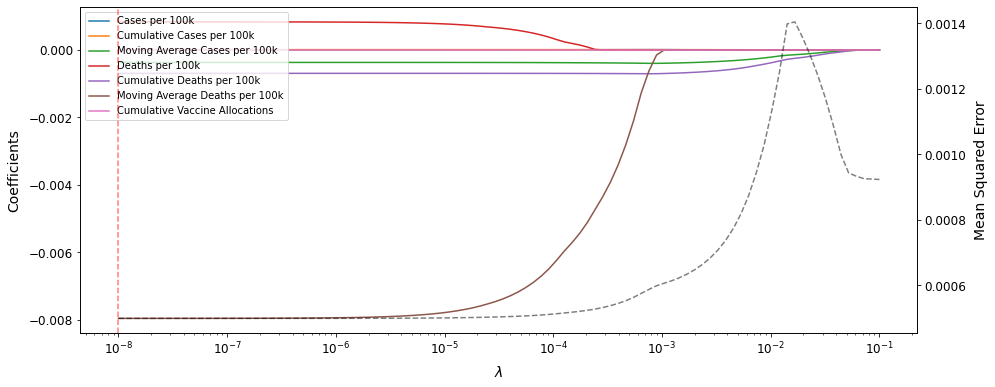

Cases per 100k:		2.037646393345448e-06

Cumulative Cases per 100k:		9.266944785992861e-06

Moving Average Cases per 100k:		-0.0003694243263428981

Deaths per 100k:		0.0008318746999187273

Cumulative Deaths per 100k:		-0.0006929915598614724

Moving Average Deaths per 100k:		-0.007951919439421477

Cumulative Vaccine Allocations:		-2.043623575275682e-09



In [69]:
alloc_dates, state_y, cumul_doses = covid_feature_extraction.cumul_doses("Georgia","GA","Short")
dates, lowndes_y, lowndes_X, feature_labels = covid_feature_extraction.county_extraction("Lowndes","Short")

padded_cumul_doses = np.pad(cumul_doses,pad_width=(lowndes_X.shape[0]-len(cumul_doses),0))
lowndes_X = np.concatenate([lowndes_X,padded_cumul_doses.reshape(len(padded_cumul_doses),1)],axis=1)

feature_labels += ["Cumulative Vaccine Allocations"]

lowndes_coefs = lasso_coefs(lowndes_X, lowndes_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print("{}:\t\t{}".format(feature_labels[i],lowndes_coefs[i]))
    print()

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Best MSE: 0.0005154990850975471


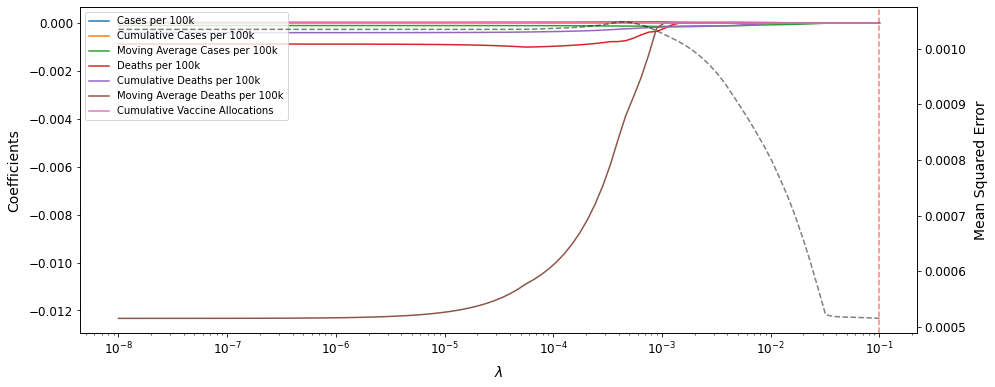

Cases per 100k:		0.0

Cumulative Cases per 100k:		-4.188046518112432e-06

Moving Average Cases per 100k:		0.0

Deaths per 100k:		0.0

Cumulative Deaths per 100k:		0.0

Moving Average Deaths per 100k:		0.0

Cumulative Vaccine Allocations:		5.798015680839547e-09



In [70]:
alloc_dates, state_y, cumul_doses = covid_feature_extraction.cumul_doses("Georgia","GA","Short")
dates, chatham_y, chatham_X, feature_labels = covid_feature_extraction.county_extraction("Chatham","Short")

padded_cumul_doses = np.pad(cumul_doses,pad_width=(chatham_X.shape[0]-len(cumul_doses),0))
chatham_X = np.concatenate([chatham_X,padded_cumul_doses.reshape(len(padded_cumul_doses),1)],axis=1)

feature_labels += ["Cumulative Vaccine Allocations"]

chatham_coefs = lasso_coefs(chatham_X, chatham_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print("{}:\t\t{}".format(feature_labels[i],chatham_coefs[i]))
    print()